In [1]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup random seed
RANDOM_SEED = 42

## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.


In [2]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000,
                  noise=0.07,
                  random_state=42)

X[:5], y[:5]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483]]),
 array([1, 1, 1, 1, 0]))

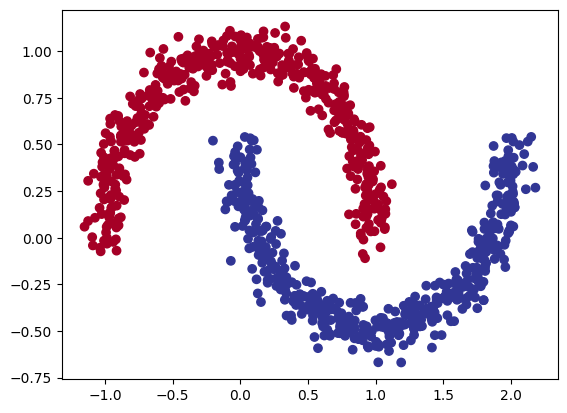

In [3]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [4]:
# Turn data into tensors of dtype float
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.2,
                                                   random_state=42)

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data



In [5]:
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
      super().__init__()

      self.layer1= nn.Linear(in_features=in_features, out_features=hidden_units)
      self.layer2= nn.Linear(in_features=hidden_units, out_features=hidden_units)
      self.layer3= nn.Linear(in_features=hidden_units, out_features=hidden_units)
      self.layer4= nn.Linear(in_features=hidden_units, out_features=out_features)
      self.relu= nn.ReLU()

    def forward(self, x):
        return self.layer4(self.relu(self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))))

# Instantiate the model
model = MoonModelV0(in_features=2,
                    out_features=1,
                    hidden_units=8).to(device)
model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.0970, -0.3267],
                      [ 0.1392, -0.5830],
                      [-0.1833,  0.1210],
                      [-0.0508,  0.4215],
                      [ 0.6726, -0.3868],
                      [-0.4514,  0.6918],
                      [-0.5630,  0.2438],
                      [ 0.6369,  0.0983]], device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.5968, -0.3114,  0.1962,  0.5433,  0.1532,  0.1034, -0.3595,  0.5237],
                     device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.0815, -0.3195,  0.2757,  0.2696,  0.0311,  0.0872,  0.1899,  0.2867],
                      [-0.1694, -0.1272,  0.3007, -0.3374,  0.1661, -0.1964, -0.0411, -0.0755],
                      [-0.0537,  0.3105, -0.1963, -0.2516, -0.1148, -0.0006,  0.2550, -0.2726],
                      [ 0.3068, -0.0908, -0.3068,  0.1351, -0.1625, -0.1386,  0.1306, -0.0600],
                      [ 0.0021,  0

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model

In [6]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

## 4. Create a training and testing loop to fit the model to the data


In [7]:
y_logits = model(X_train.to(device)[:5]).squeeze()
print("Logits:")
print(y_logits)

print("Pred probs:")
prob = torch.sigmoid(y_logits)
print(prob)

print("Pred labels:")
print(torch.round(prob))

Logits:
tensor([-0.0129, -0.0125, -0.0185, -0.0170, -0.0002], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.4968, 0.4969, 0.4954, 0.4958, 0.4999], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<RoundBackward0>)


In [8]:
# calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 12.8 MB/s eta 0:00:00


MulticlassAccuracy()

In [9]:
torch.manual_seed(42)
epochs = 1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  model.train()

  # 1. Forward pass
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train)

  # Calculate the accuracy
  acc = acc_fn(y_pred, y_train.int())

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()
  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### Testing
  model.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    y_test_logits = model(X_test).squeeze()
    y_pred = torch.round(torch.sigmoid(y_test_logits))

    # 2. Caculate the test loss/acc
    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = acc_fn(y_pred, y_test.int())

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"epoch: {epoch} | loss: {loss: .2f} | acc: {acc} | test-loss: {test_loss: .2f} | test-acc: {test_acc}")


epoch: 0 | loss:  0.69 | acc: 0.6175000071525574 | test-loss:  0.69 | test-acc: 0.6150000095367432
epoch: 100 | loss:  0.44 | acc: 0.8612499833106995 | test-loss:  0.44 | test-acc: 0.8450000286102295
epoch: 200 | loss:  0.24 | acc: 0.8849999904632568 | test-loss:  0.24 | test-acc: 0.8999999761581421
epoch: 300 | loss:  0.21 | acc: 0.9024999737739563 | test-loss:  0.20 | test-acc: 0.9049999713897705
epoch: 400 | loss:  0.16 | acc: 0.9262499809265137 | test-loss:  0.16 | test-acc: 0.925000011920929
epoch: 500 | loss:  0.09 | acc: 0.9700000286102295 | test-loss:  0.08 | test-acc: 0.9750000238418579
epoch: 600 | loss:  0.04 | acc: 0.9962499737739563 | test-loss:  0.03 | test-acc: 1.0
epoch: 700 | loss:  0.02 | acc: 0.9987499713897705 | test-loss:  0.02 | test-acc: 1.0
epoch: 800 | loss:  0.01 | acc: 0.9987499713897705 | test-loss:  0.01 | test-acc: 1.0
epoch: 900 | loss:  0.01 | acc: 1.0 | test-loss:  0.01 | test-acc: 1.0


## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [10]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

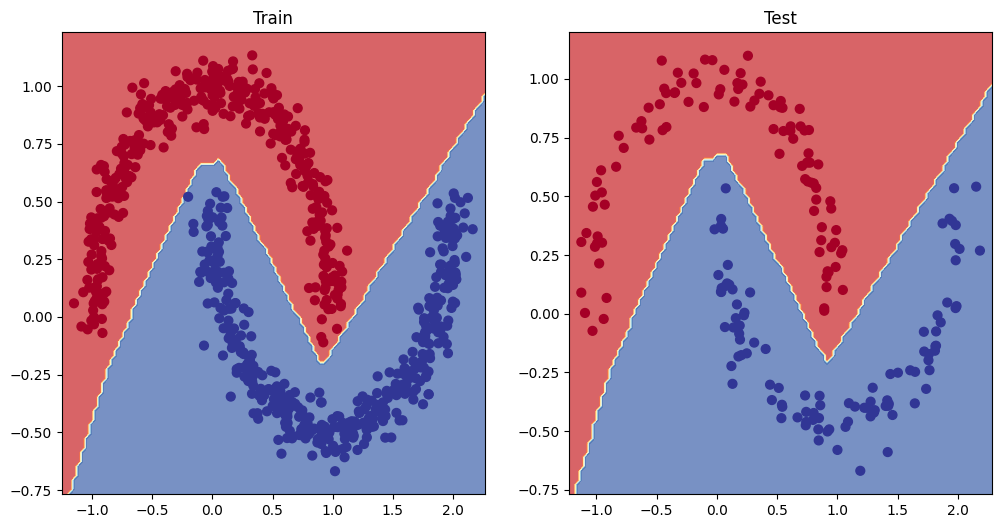

In [11]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)